In [1]:
import sys; sys.path.insert(0,'..')

import os
import torch
import re
from fastai.vision.all import *
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import NoisySpeechDataset
import time
from norse.models.dynamic_model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio
from sampler import SpeechSampler

torchaudio.set_audio_backend('sox_io')

/home/dan/anaconda3/envs/norse/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
batch_size = 128

In [3]:
dataset = NoisySpeechDataset(base_dir='../data', window_size=2)
train_dl, val_dl = SpeechSampler(dataset, .1, batch_size)()
data = DataLoaders(train_dl, val_dl).cuda()

In [4]:
net = Autoencoder(depth=6, kernel_size=32, upsample_type='transpose', skip_op='cat', pay_attention=0)

In [5]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1149058

In [19]:
def SDRLoss(output, target):
    # Check if this is ok
    dot_product = torch.sum(output * target)
    loss = (-1 * dot_product) / (torch.norm(target) * torch.norm(output))
    return loss

In [20]:
def weightedSDR(output, target):
    x = learn.xb[0]
    if x.shape != output.shape:
        output = F.pad(output, (0, 0, x.shape[-1] - output.shape[-1]))
    noise = x - target
    expected_noise = x - output 
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss + 1

In [5]:
learn = Learner(data, net, loss_func=nn.MSELoss(), cbs=[CudaCallback])#nn.MSELoss()

In [6]:
learn.model

Autoencoder(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (1): Sequential(
      (0): Conv1d(16, 32, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (2): Sequential(
      (0): Conv1d(32, 48, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (3): Sequential(
      (0): Conv1d(48, 64, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0010000000474974513)

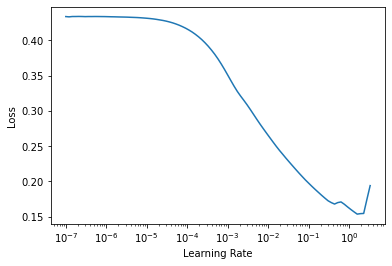

In [7]:
learn.lr_find()

In [ ]:
lr = 1e-3
lrs = slice(lr/40,lr/4)
learn.fit_one_cycle(60, lrs)#, wd=1e-2, pct_start=0.2)

epoch,train_loss,valid_loss,time
0,0.064101,0.024667,02:40
1,0.010949,0.007552,02:42
2,0.004492,0.003623,02:43
3,0.002391,0.002141,02:38
4,0.001587,0.001370,02:41
5,0.001270,0.001415,02:40
6,0.001151,0.000940,02:40
7,0.001013,0.001117,02:42
8,0.000941,0.000833,02:39
9,0.000917,0.000859,02:40


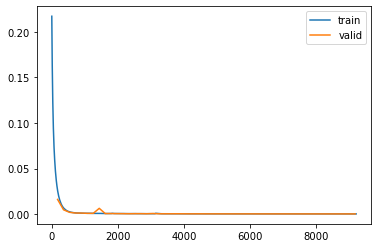

In [16]:
learn.recorder.plot_loss()

In [29]:
learn.save('16lay')

Path('models/16lay.pth')

In [7]:
learn.load('base_transp_1lay', strict=False)

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	size mismatch for decoder.0.0.weight: copying a param with shape torch.Size([16, 1, 32]) from checkpoint, the shape in current model is torch.Size([96, 80, 32]).

In [ ]:
x = 32000
learn.model()

In [9]:
from test import test
test(learn.model.eval())

PESQ: 2.5536295246441387 +- 0.1864592890597118
STOI: 0.7735541226297168 +- 0.05635645308006337


In [12]:
learn.model

Autoencoder(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (1): Sequential(
      (0): Conv1d(16, 32, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (2): Sequential(
      (0): Conv1d(32, 48, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (3): Sequential(
      (0): Conv1d(48, 64, kernel_size=(32,), stride=(2,), padding=(15,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU